# 2A.eco - Introduction au text mining

Dans ce TD, nous allons voir comment travailler avec du texte, à partir d'extraits de textes de trois auteurs, Edgar Allan Poe, (EAP), HP Lovecraft (HPL), et Mary Wollstonecraft Shelley (MWS).

Les données sont disponibles ici : [spooky.csv](https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/blob/master/data/spooky.csv).

Le but va être dans un premier temps de regarder dans le détail les termes les plus fréquents utilisés par les auteurs, de les représenter graphiquement puis on va ensuite essayer de prédire quel texte correspond à quel auteur à partir d'un modèle Word2Vec. Ce notebook librement inspiré de  : 

- https://www.kaggle.com/enerrio/scary-nlp-with-spacy-and-keras
- https://github.com/GU4243-ADS/spring2018-project1-ginnyqg
- https://www.kaggle.com/meiyizi/spooky-nlp-and-topic-modelling-tutorial/notebook

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

Parmi les concepts / packages que nous allons voir :
- [WordCloud](https://github.com/amueller/word_cloud)
- [nltk](https://www.nltk.org/)
- [Keras](https://keras.io/)
- [spacy](https://spacy.io/)

In [2]:
%matplotlib inline

## Les packages qu'on utilisera

In [3]:
#! pip install wordcloud
#!pip install gensim
#!pip install pywaffle
#!pip install keras
#!pip install tensorflow

In [4]:
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('genesis')
#nltk.download('wordnet')

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display
import base64
import string
import re
from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from pywaffle import Waffle

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [6]:
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.collocations import *
try:
    stopwords = set(stopwords.words('english'))
except LookupError:
    import nltk
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))
#stopwords

In [7]:
import os
if not os.path.exists('spooky.csv'):
    from pyensae.datasource import download_data
    download_data('spooky.csv', 
                  url='https://raw.githubusercontent.com/GU4243-ADS/spring2018-project1-ginnyqg/master/data/')

## Import des données 

In [8]:
import pandas as pd
train = pd.read_csv('spooky.csv',delimiter = ",", 
                    skiprows=1, names=['ID', 'Text', 'Author'], 
                    encoding='latin-1' ).set_index('ID')

In [9]:
train.head()

,Text,Author
ID,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


In [10]:
# Delete the word 'id' from the ID columns
train.index = [id[2:] for id in train.index]
train.head()

,Text,Author
26305,"This process, however, afforded me no means of...",EAP
17569,It never once occurred to me that the fumbling...,HPL
11008,"In his left hand was a gold snuff box, from wh...",EAP
27763,How lovely is spring As we looked from Windsor...,MWS
12958,"Finding nothing else, not even gold, the Super...",HPL


In [11]:
print('Training sample:', train['Text'][0])
print('Author of sample:', train['Author'][0])
print('Training Data Shape:', train.shape)

Training sample: This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
Author of sample: EAP
Training Data Shape: (19579, 2)


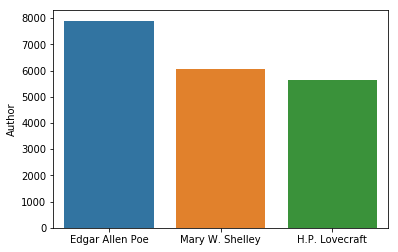

In [12]:
# Barplot of occurances of each author in the training dataset
sns.barplot(x=['Edgar Allen Poe', 'Mary W. Shelley', 'H.P. Lovecraft'], y=train['Author'].value_counts());

On se rend compte que les extraits des 3 auteurs ne sont pas forcément équilibrés dans le jeu de données. Il faudra en tenir compte dans la prédiction. 

## Bag of Words, IF TDF

L'approche bag of words : on ne tient pas compte de l'ordre des mots, ni du contexte dans lequel ils interviennent (ou alors de manière très partielle, en étudiant par exemple le mot suivant). 

L'idée est d'étudier la fréquence des mots d'un document et la surreprésentation des mots par rapport à un document de référence (appelé corpus). Cette approche un peu simpliste mais très efficace : on peut calculer des scores permettant par exemple de faire de classification automatique de document par thème, de comparer la similarité de deux documents. Elle est souvent utilisée en première analyse, et elle reste la référence pour l'analyse de textes mal structurés (tweets, dialogue tchat, etc.) Mot-clés : td-idf, indice de similarité cosine

### Fréquence d'un mot

On débute par une approche très simple, compter le nombre d'occurence d'un mot qui nous intéresse, ici on prend l'exemple du mot le  "fear" 

Et on utilise au passage un package assez sympa PyWaffle

In [13]:
train['word-fear'] = train['Text'].str.contains('fear').astype(int)
table = pd.pivot_table(train, values='word-fear', index=['Author'], aggfunc=np.sum)
data = table.to_dict()['word-fear']
data

{'EAP': 70, 'HPL': 160, 'MWS': 211}

c:\python370_x64\lib\site-packages\matplotlib\figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


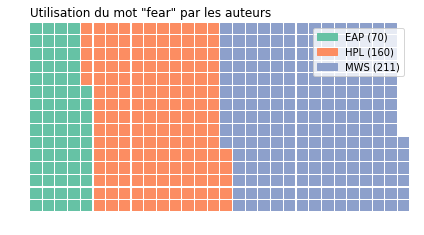

In [14]:
fig = plt.figure(
    FigureClass=Waffle, 
    rows=15, 
    values=data, 
    title={'label': 'Utilisation du mot "fear" par les auteurs', 'loc': 'left'},
    labels=["{0} ({1})".format(k, v) for k, v in data.items()],
);

### WordCloud  - premier exemple

Ici, on va un cran plus loin, on prend tous les mots des textes et on cherche à représenter la fréquence des mots utilisés par les auteurs. 

Pour cela, on va utiliser le package WordCloud - nuage de mots - qui prend en entrée une liste de mots. 

Ce package peut être très largement personnalisé, par exemple en changeant la police (par défaut, DroidSansMono)

In [15]:
# Combine all training text into one large string
all_text = ' '.join([text for text in train['Text']])
print('Number of words in all_text:', len(all_text))

Number of words in all_text: 2938231


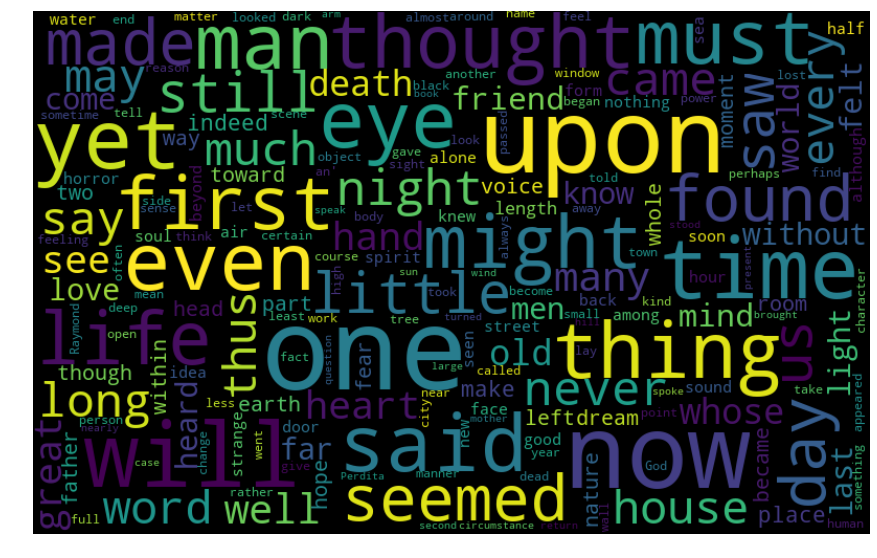

In [16]:
# Word cloud for entire training dataset
# default width=400, height=200

wordcloud = WordCloud(width=800, height=500,
                      random_state=21, max_font_size=110).generate(all_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

Si vous voulez changer la police, il faudra écrire cela ainsi :  

### Fréquence des mots

Une autre manière de voir la même chose, un histogramme avec le compte des mots les plus fréquents

In [17]:
eap = train[train['Author'] == 'EAP']
eap_text = ' '.join(text for text in eap['Text'])

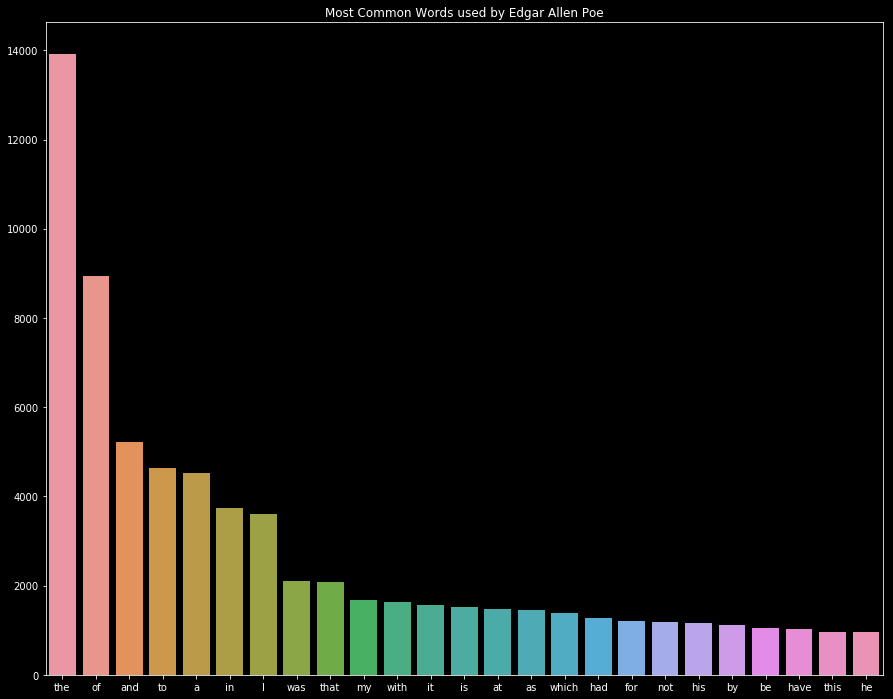

In [18]:
eap_list = eap_text.split()
eap_counts = Counter(eap_list)
eap_common_words = [word[0] for word in eap_counts.most_common(25)]
eap_common_counts = [word[1] for word in eap_counts.most_common(25)]

plt.style.use('dark_background')
plt.figure(figsize=(15, 12))

sns.barplot(x=eap_common_words, y=eap_common_counts)
plt.title('Most Common Words used by Edgar Allen Poe');

Pas très instructif.... On a beaucoup de mots "commun", comme "the", "of", "my qui ne nous intéressent pas. On va donc devoir nettoyer les textes.  

### Nettoyage du texte, suppression de la ponctuation et des stopwords

Pour "nettoyer" le texte, on utilise les fonctions [tokenizer](https://www.nltk.org/api/nltk.tokenize.html?highlight=tokenizer) de [nltk](https://www.nltk.org/).

C'est la tâche consistant à décomposer une chaîne de caractères en unités lexicales, aussi appelées tokens. Pour un ordinateur, une chaine de caractère est juste une suite de symboles, il n'est pas capable seul de déterminer quels sont les mots d'une phrase ; il n'y voit qu'une chaîne de caractères. Un processus de tokenization consiste donc à séparer ces mots, selon les espaces.

In [19]:
eap_word_list = word_tokenize(eap_text)
eap_word_list = [x.lower() for x in eap_word_list]

# ensuite, on enlève les stopswords qui sont les mots comme if, then, the, and ... ainsi que la ponctuation

eap_clean = [w.lower() for w in eap_word_list if w not in stopwords and w.isalpha()]
eap_clean = ' '.join(text.lower() for text in eap_clean)

In [20]:
eap_clean[:200] + "..."

'process however afforded means ascertaining dimensions dungeon might make circuit return point whence set without aware fact perfectly uniform seemed wall left hand gold snuff box capered hill cutting...'

Avec ce petit nettoyage, on arrive à un texte plus "pur" et plus intéressant en termes d'analyse lexicale

### Question 1)

Reproduisez le wordcloud et le graphique des fréquences sur la base du texte nettoyé de Allan Edgar Poe, que remarquez-vous ?

### Tf-IDF - le calcul de fréquence

Le calcul [tf-idf](https://fr.wikipedia.org/wiki/TF-IDF) (term frequency–inverse document frequency) permet de calculer un score de proximité entre un terme de recherche et un document (c'est ce que font les moteurs de recherche). La partie *tf* calcule une fonction croissante de la fréquence du terme de recherche dans le document à l'étude, la partie idf calcule une fonction inversement proportionnelle à la fréquence du terme dans l'ensemble des documents (ou corpus). Le score total, obtenu en multipliant les deux composantes, permet ainsi de donner un score d'autant plus élevé que le terme est surréprésenté dans un document (par rapport à l'ensemble des documents). Il existe plusieurs fonctions, qui pénalisent plus ou moins les documents longs, ou qui sont plus ou moins smooth.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=stopwords)
tfs = tfidf.fit_transform(train['Text'])

In [22]:
list(tfidf.vocabulary_.keys())[:10] + ['...']

['process',
 'however',
 'afforded',
 'means',
 'ascertaining',
 'dimensions',
 'dungeon',
 'might',
 'make',
 'circuit',
 '...']

In [23]:
feature_names = tfidf.get_feature_names()
corpus_index = [n for n in list(tfidf.vocabulary_.keys())]
import pandas as pd
df = pd.DataFrame(tfs.todense(), columns=feature_names)
#print(df)

In [24]:
df.head()

,aaem,ab,aback,abaft,abandon,abandoned,abandoning,abandonment,abaout,abased,...,zodiacal,zoilus,zokkar,zone,zones,zopyrus,zorry,zubmizzion,zuro,á¼
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.253506,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Si on repart de notre mot "fear", on va chercher les extraits où le score TF-IDF est le plus élévé. 

In [25]:
for x in df["fear"].sort_values(ascending =False).head(n=10).index : 
    print(train.iloc[x]["Text"])

We could not fear we did not.
"And now I do not fear death.
Be of heart and fear nothing.
I smiled, for what had I to fear?
Indeed I had no fear on her account.
I have not the slightest fear for the result.
At length, in an abrupt manner she asked, "Where is he?" "O, fear not," she continued, "fear not that I should entertain hope Yet tell me, have you found him?
"I fear you are right there," said the Prefect.
I went down to open it with a light heart, for what had I now to fear?
Do I fear, that my heart palpitates?


On remarque que les scores les plus élévés sont soient des extraits courts où le mot apparait une seule fois, et des extraits plus longs où le mot fear apprait plusieurs fois.

### Question 2)

Qu'en est-il pour le mot "love" ?

## Approche contextuelle : les n-gramms

L'approche contextuelle : on s'intéresse non seulement aux mots et à leur fréquence, mais aussi aux mots qui suivent. Cette approche est essentielle pour désambiguiser les homonymes. Elle permet aussi d'affiner les modèles "bag-of-words". Le calcul de n-grams (bigrams pour les co-occurences de mots deux-à-deux, tri-grams pour les co-occurences trois-à-trois, etc.) constitue la méthode la plus simple pour tenir compte du contexte.



nltk offre des methodes pour tenir compte du contexte : pour ce faire, nous calculons les n-grams, c'est-à-dire l'ensemble des co-occurrences successives de mots deux-à-deux (bigrams), trois-à-trois (tri-grams), etc.

En général, on se contente de bi-grams, au mieux de tri-grams :

- les modèles de classification, analyse du sentiment, comparaison de documents, etc. qui comparent des n-grams avec n trop grands sont rapidement confrontés au problème de données sparse, cela réduit la capacité prédictive des modèles ;
- les performances décroissent très rapidement en fonction de n, et les coûts de stockage des données augmentent rapidement (environ n fois plus élevé que la base de donnée initiale).


### Contexte du mot

In [26]:
print("Nombre de caractères : ",len(eap_clean))
print('\n')

#Tokenisation naïve sur les espaces entre les mots => on obtient une liste de mots
tokens = eap_clean.split()

#On transforme cette liste en objet nltk "Text" (objet chaine de caractère qui conserve la notion de tokens, et qui 
#comprend  un certain nombre de méthodes utiles pour explorer les données.

text = nltk.Text(tokens)

#Comme par exemple "concordance" : montre les occurences d'un mot dans son contexte
print("Exemples d'occurences du terme 'fear' :")
text.concordance("fear")
print('\n')

Nombre de caractères :  696978


Exemples d'occurences du terme 'fear' :
Displaying 24 of 24 matches:
mmitted suicide went open light heart fear reason priori diddle would diddle wit
 loud quick unequal spoken apparently fear well anger said unintelligible words 
m geneva seemed resolved give scruple fear wind night rain fell falling rain fal
hick darkness shutters close fastened fear robbers knew could see opening door k
ty ancient modes investigation smiled fear say mean average interval entire rewa
 vision need go details even went far fear occasioned much trouble might glad co
eed strong relish physical philosophy fear tinctured mind common error age mean 
ter started hourly dreams unutterable fear find hot breath thing upon face vast 
 lady seventy years age heard express fear never see marie observation attracted
od propeller must entirely remodelled fear serious accident mean steel rod vanes
illiam legrand second place impressed fear indeed impossible make comprehended g
rt move

### Co-occurences - version 1

Analyse de la fréquence des termes d'intérêt :

In [27]:
import io
f = io.StringIO()
from contextlib import redirect_stdout
with redirect_stdout(f):
    text.collocations()
print("Co-occurences fréquentes :")
print("\n".join(f.getvalue().split("\n")[:3] + ["..."]))

Co-occurences fréquentes :
main compartment; chess player; madame lalande; ourang outang; new
york; three four; tea pot; ugh ugh; could help; mille mille; said
dupin; rue morgue; right angles; every thing; monsieur maillard; von
...


Si ces mots sont très fortement associés, les expressions sont également peu fréquentes. Il est donc parfois nécessaire d'appliquer des filtres, par exemple ignorer les bigrammes qui apparaissent moins de 5 fois dans le corpus.

### Co-occurences - version 2

avec le code ci dessous, on peut choisir un peu mieux ce qui nous intéresse. 

In [28]:
finder = nltk.BigramCollocationFinder.from_words(text)

finder.apply_freq_filter(5)

bigram_measures = nltk.collocations.BigramAssocMeasures()

collocations =finder.nbest(bigram_measures.jaccard, 15) 

for collocation in collocations:
    c = ' '.join(collocation)
    print(c)

mein gott
ourang outang
hans pfaall
brevet brigadier
du roule
bas bleu
ugh ugh
tea pot
gum elastic
hu hu
prodigies valor
ha ha
mille mille
chess player
drum dow


### Co-occurences avec un mot spécifique

Ici, on va chercher quelques sont les termes fréquemment associés avec le mot "fear"

In [29]:
try:
    nltk.corpus.genesis.words('english-web.txt')
except LookupError:
    import nltk
    nltk.download('genesis')
    nltk.corpus.genesis.words('english-web.txt')

In [30]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

# Ngrams with a specific name 
name_filter = lambda *w: 'fear' not in w


## Bigrams
finder = BigramCollocationFinder.from_words(
            nltk.corpus.genesis.words('english-web.txt'))

# only bigrams that contain 'fear'
finder.apply_ngram_filter(name_filter)

# return the 100 n-grams with the highest PMI
print(finder.nbest(bigram_measures.likelihood_ratio,100))

[('fear', 'of'), ('fear', 'God'), ('I', 'fear'), ('the', 'fear'), ('The', 'fear'), ('fear', 'him'), ('you', 'fear')]


### Question 3)

Retouvez les bi-gramms les plus fréquents avec le mot "love"

## LDA 


Le modèle Latent Dirichlet Allocation (LDA) est un modèle probabiliste génératif qui permet
de décrire des collections de documents de texte ou d’autres types de données discrètes. LDA fait
partie d’une catégorie de modèles appelés “topic models”, qui cherchent à découvrir des structures
thématiques cachées dans des vastes archives de documents.


Ceci permet d’obtenir des méthodes
efficaces pour le traitement et l’organisation des documents de ces archives: organisation automatique
des documents par sujet, recherche, compréhension et analyse du texte, ou même résumer des
textes. 

Aujourd’hui, ce genre de méthodes s’utilisent fréquemment dans le web, par exemple pour
analyser des ensemble d’articles d’actualité, les regrouper par sujet, faire de la recommendation
d’articles, etc. 

### Spécification du modèle

In [31]:
try:
    nltk.download('wordnet')
except LookupError:
    import nltk
    nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xavie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
lemm = WordNetLemmatizer()

# un exemple de ce que la notion de lemmatize veut dire

print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("women")))
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("daughters")))
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: woman
The lemmatized form of leaves is: daughter
The lemmatized form of leaves is: leaf


In [33]:
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [34]:
# Storing the entire training text in a list

text = list(train.Text.values)

# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

In [35]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [36]:
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=11, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

### Représentation des résultats

In [37]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [38]:
n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 
Topic #0:
knew near raymond did hope death morning stood eye think little ground read attention know felt sense say creature sat gave table bed misery pleasure heart like till lay loved heavy high spirit desire rock hour father light presence lord
Topic #1:
make mr matter mean point fact called return present set person certain said reason case question result impossible self really doubt knowledge force ordinary merely altogether real duty discovery principle purpose course quite particular having second term perceive proportion machine
Topic #2:
left way place sea half far thing wall window ancient like possible land hill taken wood water strange black street motion right small world great short box long order little received spot having took city river shape cut said wind
Topic #3:
night thought house old earth man soon away young length men great god foot room beauty town fear people degree beneath oh remained know seen lady country happy replied street held 

In [39]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]

In [40]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]

Generating the wordcloud with the values under the category dataframe...

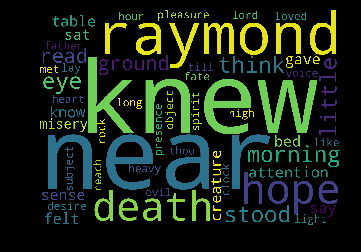

In [41]:
firstcloud = WordCloud(stopwords=stopwords,
                       background_color='black',
                       width=2500,
                       height=1800
                       ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off');

Generating the wordcloud with the values under the category dataframe...

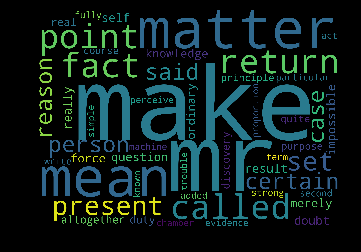

In [42]:
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]


second_cloud = WordCloud(
                          stopwords=stopwords,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words))
plt.imshow(second_cloud)
plt.axis('off');

## Prédiction - Modélisation en utilisant Word2vec et Keras

Derniere partie du TD, prédire les auteurs à partir des textes qu'on aura dans la base de test.

Pour cela, on utilise les modules spacy, Word2vec et Keras de Python. Le but ici n'est pas de connaitre par coeur toutes les fonctions utilisées, mais de comprendre comment le code fonctionne, afin de pouvoir vous en reservir si vous en avez besoin.   

In [43]:
try:
    import spacy
    nlp = spacy.load('en_core_web_sm')
except Exception as e:
    # Un message d'erreur peut apparaître.
    # cymem.cymem.Pool has the wrong size, try recompiling. Expected 64, got 48
    # Sous Windows:
    # pip install http://www.xavierdupre.fr/enseignement/setup/cymem-1.31.2-cp37-cp37m-win_amd64.whl
    # pip install http://www.xavierdupre.fr/enseignement/setup/thinc-6.10.2-cp37-cp37m-win_amd64.whl
    # pip install http://www.xavierdupre.fr/enseignement/setup/spacy-2.0.12-cp37-cp37m-win_amd64.whl
    print(e)

### Mise en forme des données

On nettoye rapidement le texte sur la base entière, en supprime la ponctuation, les stopwords, avec une autre méthode que celle vue plus haut

In [44]:
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [45]:
# Cleanup text and make sure it retains original shape
print('Original training data shape: ', train['Text'].shape)
train_cleaned = cleanup_text(train['Text'], logging=True)
print('Cleaned up training data shape: ', train_cleaned.shape)

Original training data shape:  (19579,)
Processed 1000 out of 19579 documents.
Processed 2000 out of 19579 documents.
Processed 3000 out of 19579 documents.
Processed 4000 out of 19579 documents.
Processed 5000 out of 19579 documents.
Processed 6000 out of 19579 documents.
Processed 7000 out of 19579 documents.
Processed 8000 out of 19579 documents.
Processed 9000 out of 19579 documents.
Processed 10000 out of 19579 documents.
Processed 11000 out of 19579 documents.
Processed 12000 out of 19579 documents.
Processed 13000 out of 19579 documents.
Processed 14000 out of 19579 documents.
Processed 15000 out of 19579 documents.
Processed 16000 out of 19579 documents.
Processed 17000 out of 19579 documents.
Processed 18000 out of 19579 documents.
Processed 19000 out of 19579 documents.
Cleaned up training data shape:  (19579,)


On "parse", c'est à dire qu'on parcourt, tous les textes pour les mettre en forme avant de passer dans le modèle

In [46]:
# Parse documents and print some info
print('Parsing documents...')

start = time()

train_vec = []
for doc in nlp.pipe(train_cleaned, batch_size=500):
    if doc.has_vector:
        train_vec.append(doc.vector)
    # If doc doesn't have a vector, then fill it with zeros.
    else:
        train_vec.append(np.zeros((128,), dtype="float32"))
        
train_vec = np.array(train_vec)

end = time()

print('Total time passed parsing documents: {} seconds'.format(end - start))
print('Total number of documents parsed: {}'.format(len(train_vec)))
print('Number of words in first document: ', len(train['Text'][0]))
print('Number of words in second document: ', len(train['Text'][1]))
print('Size of vector embeddings: ', train_vec.shape[1])
print('Shape of vectors embeddings matrix: ', train_vec.shape)

Parsing documents...
Total time passed parsing documents: 127.49071931838989 seconds
Total number of documents parsed: 19579
Number of words in first document:  231
Number of words in second document:  71
Size of vector embeddings:  128
Shape of vectors embeddings matrix:  (19579, 128)


In [47]:
all_text = pd.DataFrame(train, columns=['Text'])

print('Number of total text documents:', len(all_text))

Number of total text documents: 19579


In [48]:
# Define function to preprocess text for a word2vec model
def cleanup_text_word2vec(docs, logging=False):
    sentences = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents" % (counter, len(docs)))
        # Disable tagger so that lemma_ of personal pronouns (I, me, etc) don't getted marked as "-PRON-"
        doc = nlp(doc, disable=['tagger'])
        # Grab lemmatized form of words and make lowercase
        doc = " ".join([tok.lemma_.lower() for tok in doc])
        # Split into sentences based on punctuation
        doc = re.split("[\.?!;] ", doc)
        # Remove commas, periods, and other punctuation (mostly commas)
        doc = [re.sub("[\.,;:!?]", "", sent) for sent in doc]
        # Split into words
        doc = [sent.split() for sent in doc]
        sentences += doc
        counter += 1
    return sentences

!!! la cellule ci dessous prend du temps, c'est normal, on est en train de parser 15000 textes.

In [49]:
train_cleaned_word2vec = cleanup_text_word2vec(all_text['Text'], logging=True)
print('Cleaned up training data size (i.e. number of sentences): ', len(train_cleaned_word2vec))

Processed 1000 out of 19579 documents
Processed 2000 out of 19579 documents
Processed 3000 out of 19579 documents
Processed 4000 out of 19579 documents
Processed 5000 out of 19579 documents
Processed 6000 out of 19579 documents
Processed 7000 out of 19579 documents
Processed 8000 out of 19579 documents
Processed 9000 out of 19579 documents
Processed 10000 out of 19579 documents
Processed 11000 out of 19579 documents
Processed 12000 out of 19579 documents
Processed 13000 out of 19579 documents
Processed 14000 out of 19579 documents
Processed 15000 out of 19579 documents
Processed 16000 out of 19579 documents
Processed 17000 out of 19579 documents
Processed 18000 out of 19579 documents
Processed 19000 out of 19579 documents
Cleaned up training data size (i.e. number of sentences):  26930


### Le modèle Word2Vec

Ici on lui indique par combien de vecteur il faut représenter l'ensemble des mots.

In [50]:
from gensim.models.word2vec import Word2Vec

text_dim = 300

print("Training Word2Vec model...")

wordvec_model = Word2Vec(train_cleaned_word2vec, size=text_dim, window=5, min_count=3, workers=4, sg=1)

print("Word2Vec model created.")
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.vocab), text_dim))

c:\python370_x64\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Training Word2Vec model...
Word2Vec model created.
9195 unique words represented by 300 dimensional vectors


On peut ainsi demander au modèle quels sont les mots les plus similaires à d'autres d'après ces données : par exemple

In [51]:
print(wordvec_model.wv.most_similar(positive=['woman','mother']))
print(wordvec_model.wv.most_similar(positive=['love']))
print(wordvec_model.wv.most_similar(positive=['fear']))

c:\python370_x64\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('lady', 0.9182694554328918), ('son', 0.9075772762298584), ('youth', 0.9023264646530151), ('girl', 0.8979587554931641), ('child', 0.8951929211616516), ('daughter', 0.8869338035583496), ('dye', 0.8833020925521851), ('young', 0.8806361556053162), ('husband', 0.8803712129592896), ('physician', 0.8785951137542725)]
[('affection', 0.8903218507766724), ('creature', 0.8834965229034424), ('thy', 0.8802502751350403), ('grief', 0.8715649247169495), ('sympathy', 0.867340624332428), ('tender', 0.8555741906166077), ('spirit', 0.8547770380973816), ('affectionate', 0.85402512550354), ('sorrow', 0.8540093302726746), ('gift', 0.8539726138114929)]
[('madness', 0.8873082399368286), ('sympathize', 0.8867038488388062), ('hope', 0.8852324485778809), ('forget', 0.8828439116477966), ('recall', 0.8813920021057129), ('freedom', 0.8793625235557556), ('woodville', 0.8785386681556702), ('expectation', 0.8782422542572021), ('fancy', 0.877665102481842), ('survive', 0.8751451969146729)]


In [52]:
# Define function to create word vectors given a cleaned piece of text.
def create_average_vec(doc):
    average = np.zeros((text_dim,), dtype='float32')
    num_words = 0.
    for word in doc.split():
        if word in wordvec_model.wv.vocab:
            average = np.add(average, wordvec_model[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

In [53]:
# Counting the number of empty strings are in train_cleaned
count = 0
for i in range(len(train_cleaned)):
    if train_cleaned[i] == "":
        print("index:", i)
        count += 1
print(count)

index: 477
index: 1023
index: 3601
index: 8654
4


In [54]:
# Create word vectors
train_cleaned_vec = np.zeros((train.shape[0], text_dim), dtype="float32")  # 19579 x 300
for i in range(len(train_cleaned)):
    train_cleaned_vec[i] = create_average_vec(train_cleaned[i])

print("Train word vector shape:", train_cleaned_vec.shape)

c:\python370_x64\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


Train word vector shape: (19579, 300)


In [55]:
from sklearn.preprocessing import label_binarize

# Transform labels into one hot encoded format.
y_train_ohe = label_binarize(train['Author'], classes=['EAP', 'HPL', 'MWS'])
print('y_train_ohe shape: {}'.format(y_train_ohe.shape))
print('y_train_ohe samples:')
print(y_train_ohe[:5])

y_train_ohe shape: (19579, 3)
y_train_ohe samples:
[[1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]]


In [56]:
from sklearn.model_selection import train_test_split

# If using spaCy word vectors
# X_train, X_test, y_train, y_test = train_test_split(train_vec, y_train_ohe, test_size=0.2, random_state=21)
# If using Word2Vec word vectors
X_train, X_test, y_train, y_test = train_test_split(train_cleaned_vec, y_train_ohe, test_size=0.2, random_state=21)

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))

X_train size: (15663, 300)
X_test size: (3916, 300)
y_train size: (15663, 3)
y_test size: (3916, 3)


### Identification d'un auteur

``y_train`` contient un entier correspond à un des trois auteurs considérés.

In [57]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD

def build_model():
    model = Sequential()
        # Densely Connected Neural Network (Multi-Layer Perceptron)
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=300))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model

Using TensorFlow backend.


Définit un modèle keras.

In [58]:
model = build_model()  #('mlp')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               154112    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
__________

Compilaton du modèle.

In [59]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])

Une fois le modèle spécifié, il faut encore lui indiquer combien de fois il devrait être appliqué aux données. 
C'est la notion d'epochs > "generally defined as "one pass over the entire dataset".

In [60]:
# Define number of epochs
epochs = 50

# Fit the model to the training data
estimator = model.fit(X_train, y_train,
                      validation_split=0.2,
                      epochs=epochs, batch_size=128, verbose=100)

Train on 12530 samples, validate on 3133 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [61]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 72.23% / Validation accuracy: 72.29%


c:\python370_x64\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
c:\python370_x64\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


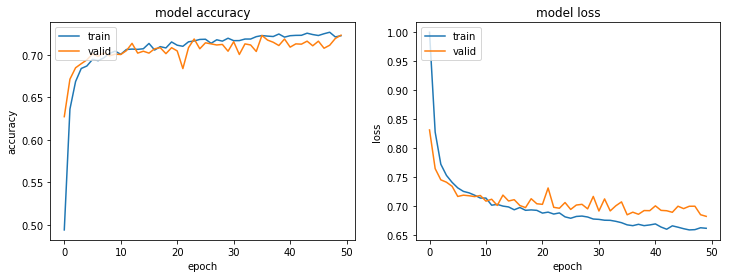

In [62]:
# Plot model accuracy over epochs
fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.reset_orig()   # Reset seaborn settings to get rid of black background
ax[0].plot(estimator.history['acc'])
ax[0].plot(estimator.history['val_acc'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'valid'], loc='upper left')

# Plot model loss over epochs
ax[1].plot(estimator.history['loss'])
ax[1].plot(estimator.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'valid'], loc='upper left');

In [63]:
# Make predictions
predicted_prob = model.predict(X_test)
print(predicted_prob.shape)

(3916, 3)


In [64]:
predicted_prob, y_test

(array([[0.04206201, 0.01520577, 0.94273216],
        [0.12521498, 0.319187  , 0.5555981 ],
        [0.1312831 , 0.06028916, 0.8084277 ],
        ...,
        [0.01733347, 0.00155359, 0.98111296],
        [0.16858503, 0.22053304, 0.6108819 ],
        [0.03446764, 0.02124828, 0.9442841 ]], dtype=float32),
 array([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1]]))